<a href="https://colab.research.google.com/github/alizzouz/cnn-vgg16/blob/main/Catsdogsvgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG-16**

In [3]:
! pip install -q kaggle

In [4]:
#création un dossier kaggle
! mkdir ~/.kaggle/

In [6]:
! cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 96% 759M/788M [00:03<00:00, 282MB/s]
100% 788M/788M [00:03<00:00, 258MB/s]


In [ ]:
! unzip /content/microsoft-catsvsdogs-dataset.zip -d cats_dogs_data

Streaming output truncated to the last 5000 lines.
  inflating: cats_dogs_data/PetImages/Dog/550.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5500.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5501.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5502.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5503.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5504.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5505.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5506.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5507.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5508.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5509.jpg  
  inflating: cats_dogs_data/PetImages/Dog/551.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5510.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5511.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5512.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5513.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5514.jpg  
  inflating: cats_dogs_data/PetImages/Dog/5515.jpg

# importation des packages nécessaires





In [22]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import shutil, sys 
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
from keras.preprocessing import image


from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten,BatchNormalization
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

## **Préparation de données**

In [10]:
source_path = '/content/drive/MyDrive/Kaggle/cats_dogs_data/PetImages'
source_path_dogs = os.path.join(source_path, 'Dog')    
source_path_cats = os.path.join(source_path, 'Cat')    

In [11]:
root_dir = '/content/drive/MyDrive/Kaggle/cats_dogs_dats'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

In [ ]:

def create_train_val_dirs(root_path):
  os.mkdir(root_path)
  train_dir = os.path.join(root_path, 'training')
  os.mkdir(train_dir)
  val_dir = os.path.join(root_path, 'validation')
  os.mkdir(val_dir)
  cat_train_dir = os.path.join(train_dir, 'cats')
  os.mkdir(cat_train_dir)
  dog_train_dir = os.path.join(train_dir, 'dogs')
  os.mkdir(dog_train_dir)

  cat_val_dir = os.path.join(val_dir, 'cats')
  os.mkdir(cat_val_dir)
  dog_val_dir = os.path.join(val_dir, 'dogs')
  os.mkdir(dog_val_dir)
#Exception pour gérer l'erreur de l'éxistence des dossiers 
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/drive/MyDrive/Kaggle/cats_dogs_dats/training
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation
/content/drive/MyDrive/Kaggle/cats_dogs_dats/training/cats
/content/drive/MyDrive/Kaggle/cats_dogs_dats/training/dogs
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation/cats
/content/drive/MyDrive/Kaggle/cats_dogs_dats/validation/dogs


In [14]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  source_list = os.listdir(SOURCE_DIR)
  train_list = random.sample(source_list, int(len(source_list)*SPLIT_SIZE))
  for img in source_list:
    if os.path.getsize(os.path.join(SOURCE_DIR, img)) == 0:
      print(img + "is zero length, so ignoring.")
    elif img in train_list:
      copyfile(os.path.join(SOURCE_DIR, img), os.path.join(TRAINING_DIR, img))
    else:
      copyfile(os.path.join(SOURCE_DIR, img), os.path.join(VALIDATION_DIR, img))

In [12]:
CAT_SOURCE_DIR = "/content/drive/MyDrive/kaggle/catvsdog/PetImages/Cat"
DOG_SOURCE_DIR = "/content/drive/MyDrive/kaggle/catvsdog/PetImages/Dog"

TRAINING_DIR = "/content/drive/MyDrive/kaggle/catsvsdogss/training"
VALIDATION_DIR = "/content/drive/MyDrive/kaggle/catsvsdogss/validation"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/") 
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Répertoires vides au cas où vous exécuteriez cette cellule plusieurs fois
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Définir la proportion d'images utilisées pour le train
split_size = .9

In [15]:

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

print(f"\n\nLe répertoire d'origine cats contient {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Le répertoire d'origine dogs contient {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"Il y a {len(os.listdir(TRAINING_CATS_DIR))} images cats pour le training")
print(f"Il y a {len(os.listdir(TRAINING_DOGS_DIR))} images dogs pour le training")
print(f"Il y a {len(os.listdir(VALIDATION_CATS_DIR))} images cats pour la validation")
print(f"Il y a {len(os.listdir(VALIDATION_DOGS_DIR))} images dogs pour la validation")

666.jpgis zero length, so ignoring.
11702.jpgis zero length, so ignoring.


Le répertoire d'origine cats contient 12501 images
Le répertoire d'origine dogs contient 12501 images

Il y a 11249 images cats pour le training
Il y a 11249 images dogs pour le training
Il y a 1251 images cats pour la validation
Il y a 1251 images dogs pour la validation


In [16]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale=1/255)    

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,             
                                                      class_mode='binary',       
                                                      target_size=(150, 150))    

    validation_datagen = ImageDataGenerator(rescale=1/255)
   
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [17]:
#Test de la fonction
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [18]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5,     
                          verbose=1,      
                          mode='auto'   
                         )

In [19]:
callbacks = [earlystop]

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
vgg16_model = VGG16(weights = 'imagenet', include_top = False)  
                                                               
x = vgg16_model.output  
x = GlobalAveragePooling2D()(x)     
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation = 'sigmoid')(x)  
model1 = Model(inputs = vgg16_model.input, outputs = predictions)  

58889256/58889256 [==============================] - 1s 0us/step


In [25]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [28]:
# Compiler le nouveau modèle à l'aide d'un optimiseur "adam"
model1.compile(optimizer = 'adam',
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])

In [29]:
# fit le model
vgg16_history = model1.fit_generator(
    train_generator,
    epochs = 20,    #20 epoch
    validation_data = validation_generator,
    callbacks=callbacks)

<ipython-input-29-8ee62c1f50ae>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history = model1.fit_generator(


Epoch 1/20
1106/1125 [============================>.] - ETA: 1s - loss: 0.2802 - accuracy: 0.8776

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

1125/1125 [==============================] - 132s 110ms/step - loss: 0.2793 - accuracy: 0.8780 - val_loss: 0.2315 - val_accuracy: 0.8981
Epoch 2/20
1125/1125 [==============================] - 120s 106ms/step - loss: 0.2366 - accuracy: 0.8998 - val_loss: 0.2287 - val_accuracy: 0.9005
Epoch 3/20
1125/1125 [==============================] - 119s 106ms/step - loss: 0.2210 - accuracy: 0.9054 - val_loss: 0.2650 - val_accuracy: 0.8825
Epoch 4/20
1125/1125 [==============================] - 119s 106ms/step - loss: 0.2115 - accuracy: 0.9102 - val_loss: 0.2237 - val_accuracy: 0.9041
Epoch 5/20
1125/1125 [==============================] - 119s 106ms/step - loss: 0.1982 - accuracy: 0.9179 - val_loss: 0.2040 - val_accuracy: 0.9137
Epoch 6/20
1125/1125 [==============================] - 119s 106ms/step - loss: 0.1892 - accuracy: 0.9217 - val_loss: 0.2581 - val_accuracy: 0.8869
Epoch 7/20
1125/1125 [==============================] - 123s 109ms/step - loss: 0.1787 - accuracy: 0.9259 - val_loss: 0.210

In [31]:
acc=vgg16_history.history['accuracy']
val_acc=vgg16_history.history['val_accuracy']
loss=vgg16_history.history['loss']
val_loss=vgg16_history.history['val_loss']

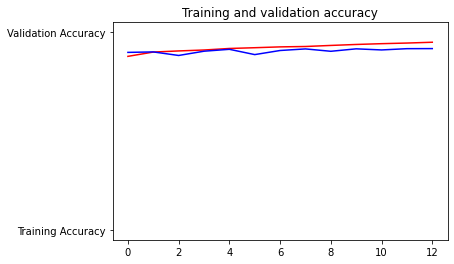

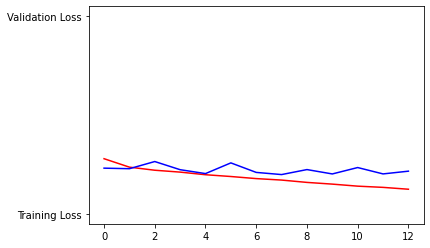

In [32]:
epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()